In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [26]:
# define some function to use

from matplotlib import pyplot as plt
import seaborn as sns

def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize=(5,5))
    labels = ['No', 'Yes']
    sns.heatmap(cm, annot=True, fmt="d", xticklabels = labels, yticklabels = labels)
    plt.title('Confusion matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def auc(y_test, y_pred):
    le = LabelEncoder()
    y1 = le.fit_transform(y_test)
    y2 = le.fit_transform(y_pred)
    auc_score = roc_auc_score(y1,y2)
    return auc_score

In [ ]:

"""
#plot
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharey=True, figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels = labels, yticklabels = labels, ax = ax1)
sns.heatmap(cm_pc2, annot=True, fmt='d', xticklabels = labels, yticklabels = labels, ax = ax2)
sns.heatmap(cm_pc5, annot=True, fmt='d', xticklabels = labels, yticklabels = labels, ax = ax3)
sns.heatmap(cm_pc10, annot=True, fmt='d', xticklabels = labels, yticklabels = labels, ax = ax4)
ax1.set_title(label_list[0])
ax2.set_title(label_list[1])
ax3.set_title(label_list[2])
ax4.set_title(label_list[3])
"""

## Load Data

In [39]:
train_df = pd.read_csv('/content/drive/My Drive/HW/DMA2/training.csv')  
test_df = pd.read_csv('/content/drive/My Drive/HW/DMA2/testing.csv')  
print('training size : ', train_df.shape[0]) 
print('testing size : ', test_df.shape[0])  
print('Features : \n', train_df.columns)

train_df.head(5)

training size :  1177
testing size :  293
Features : 
 Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,3,2,Sales Executive,4,Single,5993,8,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,2,2,Research Scientist,2,Married,5130,1,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,2,1,Laboratory Technician,3,Single,2090,6,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,5,4,Female,3,1,Research Scientist,3,Married,2909,1,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,7,1,Male,3,1,Laboratory Technician,2,Married,3468,9,3,4,1,6,3,3,2,2,2,2


## Preprocess

#### onthot

In [40]:
X_train, y_train = train_df.loc[:, train_df.columns != 'Attrition'], train_df['Attrition']
X_test, y_test = test_df.loc[:, test_df.columns != 'Attrition'], test_df['Attrition']

In [41]:
categorical_columns = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
X_train = pd.get_dummies(X_train, columns = categorical_columns, prefix = categorical_columns)
X_test = pd.get_dummies(X_test, columns = categorical_columns, prefix = categorical_columns)
X_train.head(5)

,Age,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,2,1,2,3,2,4,5993,8,3,1,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,8,1,2,3,2,2,2,5130,1,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,37,2,2,4,4,2,1,3,2090,6,3,2,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,33,3,4,5,4,3,1,3,2909,1,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,2,1,7,1,3,1,2,3468,9,3,4,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


#### define oversample function

In [42]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# define oversampling function
def oversam(X_train, y_train, mode = 'SMOTE'):
    col = X_train.columns

    if mode == 'SMOTE':
    oversampler = SMOTE(ratio='minority')
    elif mode == 'SMOTETomek':
    oversampler = SMOTETomek(ratio='minority')
    elif mode == 'SMOTEENN':
    oversampler = SMOTEENN(ratio='minority')
    X_train, y_train = oversampler.fit_sample(X_train, y_train)
    X_train = pd.DataFrame(X_train, columns = col)
    y_train = pd.Series(y_train)

    return X_train, y_train 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

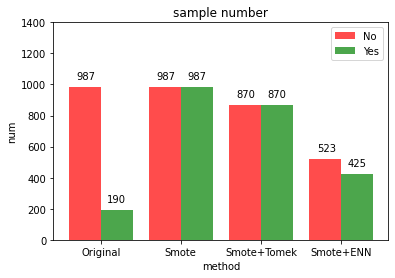

In [43]:
# plot graph to see the nuber of each class between different over sampling method

x_smote, y_smote = oversam(X_train, y_train, mode = 'SMOTE')
x_smote_to, y_smote_to = oversam(X_train, y_train, mode = 'SMOTETomek')
x_smote_enn, y_smote_enn = oversam(X_train, y_train, mode = 'SMOTEENN')

label_list = ['Original', 'Smote', 'Smote+Tomek', 'Smote+ENN']
num_list1 = [y_train.value_counts()[0], y_smote.value_counts()[0], y_smote_to.value_counts()[0], y_smote_enn.value_counts()[0]]      
num_list2 = [y_train.value_counts()[1], y_smote.value_counts()[1], y_smote_to.value_counts()[1], y_smote_enn.value_counts()[1]] 

x = range(len(num_list1))
rects1 = plt.bar(x = x, height = num_list1, width=0.4, alpha=0.7, color='red', label='No')
for i in range(len(num_list1)):
    plt.text(i-0.1, y = num_list1[i]+50, s = num_list1[i])
rects2 = plt.bar(x=[i + 0.4 for i in x], height = num_list2, width=0.4, alpha=0.7, color='green', label='Yes')
for i in range(len(num_list2)):
    plt.text(i+0.28, y = num_list2[i]+50, s = num_list2[i])
plt.ylim(0, 1400)
plt.ylabel("num")
plt.xticks([index + 0.2 for index in x], label_list)
plt.xlabel("method")
plt.title("sample number")
plt.legend()

#### define PCA function

In [44]:
from sklearn.decomposition import PCA

def pca_dec(X_train, X_test, n): 
    pca = PCA(n_components = n)
    pca.fit(X_train)
    pca.fit(X_test)
    X_train_pc = pca.transform(X_train)
    X_test_pc = pca.transform(X_test)
    return X_train_pc, X_test_pc

## define Classifier

#### rf

AUC :  0.5916796402006572 

              precision    recall  f1-score   support

          No       0.87      0.99      0.92       246
         Yes       0.82      0.19      0.31        47

    accuracy                           0.86       293
   macro avg       0.84      0.59      0.62       293
weighted avg       0.86      0.86      0.83       293



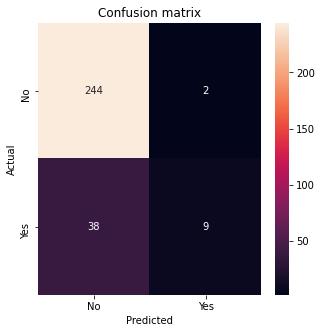

In [86]:
def rf (X_train, y_train, X_test, y_test, plot = False, report = False):
    rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 1234)
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    print('AUC : ', auc(y_test, y_pred),'\n')
    if report:
        print(classification_report(y_test, y_pred))
    if plot:
        plot_cm(y_test, y_pred)

    return y_pred

y_pred = rf(X_train, y_train, X_test, y_test, plot = True, report = True)

##### test different parameter of RF (but it seems no difference)

              precision    recall  f1-score   support

          No       0.86      1.00      0.92       246
         Yes       1.00      0.13      0.23        47

    accuracy                           0.86       293
   macro avg       0.93      0.56      0.57       293
weighted avg       0.88      0.86      0.81       293

AUC :  0.5638297872340425


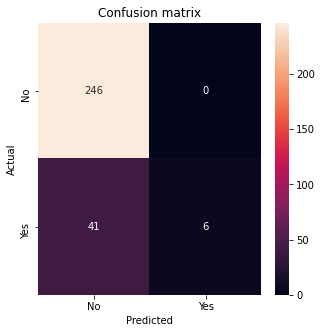

In [46]:
# test oter parameter (max_features, max_depth)
rf_clf = RandomForestClassifier(n_estimators = 100, max_features = 'sqrt', max_depth = 10)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('AUC : ', auc(y_test, y_pred))
plot_cm(y_test, y_pred)

              precision    recall  f1-score   support

          No       0.86      1.00      0.92       246
         Yes       0.86      0.13      0.22        47

    accuracy                           0.86       293
   macro avg       0.86      0.56      0.57       293
weighted avg       0.86      0.86      0.81       293

AUC :  0.5617972669088392


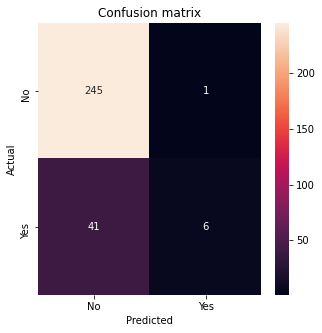

In [47]:
# test oter parameter (class_weight)
rf_clf = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced')
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('AUC : ', auc(y_test, y_pred))
plot_cm(y_test, y_pred)

Least important feature :  EducationField_Human Resources 


              precision    recall  f1-score   support

          No       0.86      1.00      0.92       246
         Yes       0.88      0.15      0.25        47

    accuracy                           0.86       293
   macro avg       0.87      0.57      0.59       293
weighted avg       0.86      0.86      0.82       293

AUC :  0.5724355647811797


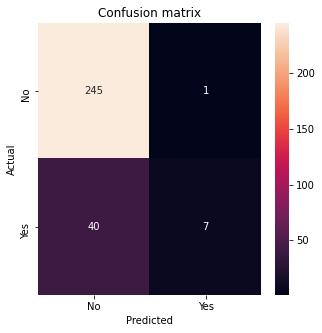

In [48]:
# delete the less important feature
less_imp = X_train.columns[np.argmin(rf_clf.feature_importances_)]
print('Least important feature : ', less_imp, '\n\n')
X_train_drop = X_train.drop([less_imp], axis=1)
X_test_drop = X_test.drop([less_imp], axis=1)

rf_clf = RandomForestClassifier(n_estimators = 100)
rf_clf.fit(X_train_drop, y_train)
y_pred = rf_clf.predict(X_test_drop)
print(classification_report(y_test, y_pred))
print('AUC : ', auc(y_test, y_pred))
plot_cm(y_test, y_pred)

#### svm

AUC :  0.5 

              precision    recall  f1-score   support

          No       0.84      1.00      0.91       246
         Yes       0.00      0.00      0.00        47

    accuracy                           0.84       293
   macro avg       0.42      0.50      0.46       293
weighted avg       0.70      0.84      0.77       293



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


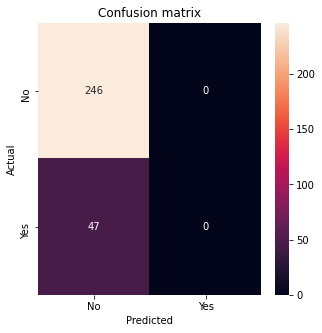

In [49]:
def svc(X_train, y_train, X_test, y_test, plot = False, report = False):
    svm_clf = SVC(kernel = 'rbf')
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    print('AUC : ', auc(y_test, y_pred),'\n')
    if report:
    print(classification_report(y_test, y_pred))
    if plot:
    plot_cm(y_test, y_pred)
    return y_pred


y_pred = svc(X_train, y_train, X_test, y_test, plot = True, report = True)

#### xgb

AUC :  0.5982528974225912 

              precision    recall  f1-score   support

          No       0.87      0.98      0.92       246
         Yes       0.71      0.21      0.33        47

    accuracy                           0.86       293
   macro avg       0.79      0.60      0.62       293
weighted avg       0.84      0.86      0.83       293



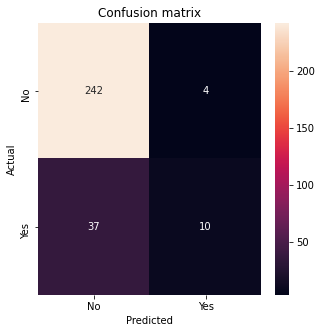

In [50]:
from xgboost import XGBClassifier

def xgb(X_train, y_train, X_test, y_test, plot = False, report = False):
    xgb_clf = XGBClassifier()
    xgb_clf.fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    print('AUC : ', auc(y_test, y_pred), '\n')
    if report:
        print(classification_report(y_test, y_pred))
    if plot:
        plot_cm(y_test, y_pred)
    return y_pred


y_pred = xgb(X_train, y_train, X_test, y_test, plot = True, report = True)

## Experiment

#### overall (all classifier without oversampling and pca)

In [92]:
# X_train, X_test, y_train, y_test (has been done one-hot for catagorical features)

# fit into classifier
print('\n\nRandom Forest : \n')
y_pred_rf = rf(X_train, y_train, X_test, y_test, plot = False, report = True)
print('\n\nSVC : \n')
y_pred_rf = svc(X_train, y_train, X_test, y_test, plot = False, report = True)
print('\n\nXGBoost : \n')
y_pred_rf = xgb(X_train, y_train, X_test, y_test, plot = False, report = True)



Random Forest : 

AUC :  0.5916796402006572 

              precision    recall  f1-score   support

          No       0.87      0.99      0.92       246
         Yes       0.82      0.19      0.31        47

    accuracy                           0.86       293
   macro avg       0.84      0.59      0.62       293
weighted avg       0.86      0.86      0.83       293



SVC : 

AUC :  0.5 

              precision    recall  f1-score   support

          No       0.84      1.00      0.91       246
         Yes       0.00      0.00      0.00        47

    accuracy                           0.84       293
   macro avg       0.42      0.50      0.46       293
weighted avg       0.70      0.84      0.77       293



XGBoost : 



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC :  0.5982528974225912 

              precision    recall  f1-score   support

          No       0.87      0.98      0.92       246
         Yes       0.71      0.21      0.33        47

    accuracy                           0.86       293
   macro avg       0.79      0.60      0.62       293
weighted avg       0.84      0.86      0.83       293



#### four oversampling method effect (Random Forest)

In [225]:
# to see four oversampling method with Random Forest

x_smote, y_smote = oversam(X_train, y_train, mode = 'SMOTE')
x_smote_to, y_smote_to = oversam(X_train, y_train, mode = 'SMOTETomek')
x_smote_enn, y_smote_enn = oversam(X_train, y_train, mode = 'SMOTEENN')
label_list = ['Original', 'Smote', 'Smote+Tomek', 'Smote+ENN']
labels = ['No', 'Yes']

print('\n\nOriginal : \n')
y_pred = rf(X_train, y_train, X_test, y_test)
print('\n\nSMOTE : \n')
y_pred_smote = rf(x_smote, y_smote, X_test, y_test)
print('\n\nSMOTE + Tomek : \n')
y_pred_smotetomek = rf(x_smote_to, y_smote_to, X_test, y_test)
print('\n\nSMOTE + ENN : \n')
y_pred_smoteenn = rf(x_smote_enn, y_smote_enn, X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni



Original : 

AUC :  0.5916796402006572 



SMOTE : 

AUC :  0.6367410482615464 



SMOTE + Tomek : 

AUC :  0.6286109669607334 



SMOTE + ENN : 

AUC :  0.7110793980280229 



#### with and without pca (Random Forest) 

In [119]:
# to see how PCA effect with Random Forest

x_train_pc2, x_test_pc2 = pca_dec(X_train, X_test, 2)
x_train_pc5, x_test_pc5 = pca_dec(X_train, X_test, 5)
x_train_pc10, x_test_pc10 = pca_dec(X_train, X_test, 10)

label_list = ['Original', 'pca with 2 component', 'pca with 5 component', 'pca with 10 component']
labels = ['No', 'Yes']

print('\n\nPCA with n = 2 : ')
y_pred_2 = rf(x_train_pc2, y_train, x_test_pc2, y_test)
print('\n\nPCA with n = 5 : ')
y_pred_5 = rf(x_train_pc5, y_train, x_test_pc5, y_test)
print('\n\nPCA with n = 10 : ')
y_pred_10 = rf(x_train_pc10, y_train, x_test_pc10, y_test)




PCA with n = 2 : 
AUC :  0.5242605085625324 



PCA with n = 5 : 
AUC :  0.5749437813527072 



PCA with n = 10 : 
AUC :  0.5536671856080263 



#### overasmpling + pca (Random Forest) 

In [37]:
# do oversample for training data 
# here I choose Smote+ENN method
X_train_over, y_train_over = oversam(X_train, y_train, mode = 'SMOTEENN')

# do pca 
X_train_pc2, X_test_pc2 = pca_dec(X_train_over, X_test, 2)
X_train_pc5, X_test_pc5 = pca_dec(X_train_over, X_test, 10)
X_train_pc10, X_test_pc10 = pca_dec(X_train_over, X_test, 10)

# fit into random forest
print('\n\nOversample + PCA with n = 2\n')
y_pred_2 = rf(X_train_pc2, y_train_over, X_test_pc2, y_test)
print('\n\nOversample + PCA with n = 5\n')
y_pred_5 = rf(X_train_pc5, y_train_over, X_test_pc5, y_test)
print('\n\nOversample + PCA with n = 10\n')
y_pred_10 = rf(X_train_pc10, y_train_over, X_test_pc10, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni



Oversample + PCA with n = 2

AUC :  0.6013233004670472 



Oversample + PCA with n = 5

AUC :  0.6141238540044974 



Oversample + PCA with n = 10

AUC :  0.5892579138557342 



`
but it seems that with oversampling and pca didn't go well, so I will not use pca
`

#### overall (all classifier with oversampling)

In [181]:
# X_train, X_test, y_train, y_test (has been done one-hot for catagorical features)

# oversaampling
# here I choose Smote+ENN method
X_train_over, y_train_over = oversam(X_train, y_train, mode = 'SMOTEENN')

# fit into classifier
print('\n\nRandom Forest : \n')
y_pred_rf = rf(X_train_over, y_train_over, X_test, y_test, plot = False, report = True)
print('\n\nSVC : \n')
y_pred_rf = svc(X_train_over, y_train_over, X_test, y_test, plot = False, report = True)
print('\n\nXGBoost : \n')
y_pred_rf = xgb(X_train_over, y_train_over, X_test, y_test, plot = False, report = True)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni



Random Forest : 

AUC :  0.7110793980280229 

              precision    recall  f1-score   support

          No       0.91      0.89      0.90       246
         Yes       0.48      0.53      0.51        47

    accuracy                           0.83       293
   macro avg       0.69      0.71      0.70       293
weighted avg       0.84      0.83      0.84       293



SVC : 

AUC :  0.6271406331084587 

              precision    recall  f1-score   support

          No       0.90      0.66      0.76       246
         Yes       0.25      0.60      0.35        47

    accuracy                           0.65       293
   macro avg       0.57      0.63      0.56       293
weighted avg       0.79      0.65      0.69       293



XGBoost : 

AUC :  0.703425012973534 

              precision    recall  f1-score   support

          No       0.91      0.85      0.88       246
         Yes       0.42      0.55      0.48        47

    accuracy                           0.81       293
 